In [17]:
import pandas as pd
from datetime import date, timedelta
import win32com.client as win32
import teradatasql
import seaborn as sns
from phik.report import plot_correlation_matrix
from phik import report
import matplotlib.pyplot as plt
import pygwalker as pyg
import folium 
from folium.plugins import MarkerCluster, HeatMap
import requests
from xml.etree import ElementTree
import numpy as np

In [18]:
user="vitaly.flerin"
password="4GyyERMq!!!"
query = '''select * from uat_ca.vf_rostov_research_12072023'''

In [19]:
with teradatasql.connect(host="td2800.corp.tele2.ru", user=user, password=password,logmech="ldap", tmode="TERA" ) as connect:
    df = pd.read_sql(query, connect)
df

C:\Users\vitaly.flerin\AppData\Local\Temp\ipykernel_12864\4148601419.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connect)


,subs_id,sector_name,BS_POSITION,coeff_80,tech_score,top_3,coeff_80_new,LON,LAT,ST_POINT
0,12888958.0,RO1036_014,POINT (39.622052 47.226352),0.177082,1,1,1.77081972004213E-001,39.622052,47.226352,POINT (39.622052 47.226352)
1,55547641.0,RO0854_013,POINT (41.034444 47.975),0.001193,1,3,1.19275273255094E-003,41.034444,47.975000,POINT (41.034444 47.975)
2,49028625.0,RO0046_016,POINT (39.811944 47.237333),0.007338,1,3,7.33773998945939E-003,39.811944,47.237333,POINT (39.811944 47.237333)
3,33686957.0,RO3540_2,POINT (40.084222 47.406389),0.005696,1,3,5.69560514303939E-003,40.084222,47.406389,POINT (40.084222 47.406389)
4,36561037.0,RO3075_9,POINT (39.743861 47.25125),0.104171,1,1,1.04171420055558E-001,39.743861,47.251250,POINT (39.743861 47.25125)
...,...,...,...,...,...,...,...,...,...,...
774847,60633399.0,RO2079_011,POINT (40.318925 48.635794),0.000000,1,2,not_bad_coeff,40.318925,48.635794,POINT (40.318925 48.635794)
774848,52872004.0,RO3399_6,POINT (39.619909 47.21626),0.003220,1,1,3.21959739247792E-003,39.619909,47.216260,POINT (39.619909 47.21626)
774849,32716351.0,RO4543_2,POINT (39.723306 47.1475),0.018510,1,2,1.85097634600694E-002,39.723306,47.147500,POINT (39.723306 47.1475)
774850,32716351.0,RO3100_2,POINT (39.708611 47.139167),0.083321,1,1,8.33205502170503E-002,39.708611,47.139167,POINT (39.708611 47.139167)


In [20]:
print(f'Общее количество уникальных детракторов в витрине: {df.subs_id.nunique()}') # уникальных абонов

Общее количество уникальных детракторов в витрине: 264768


c:\Users\vitaly.flerin\Miniconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<Axes: xlabel='LON', ylabel='LAT'>

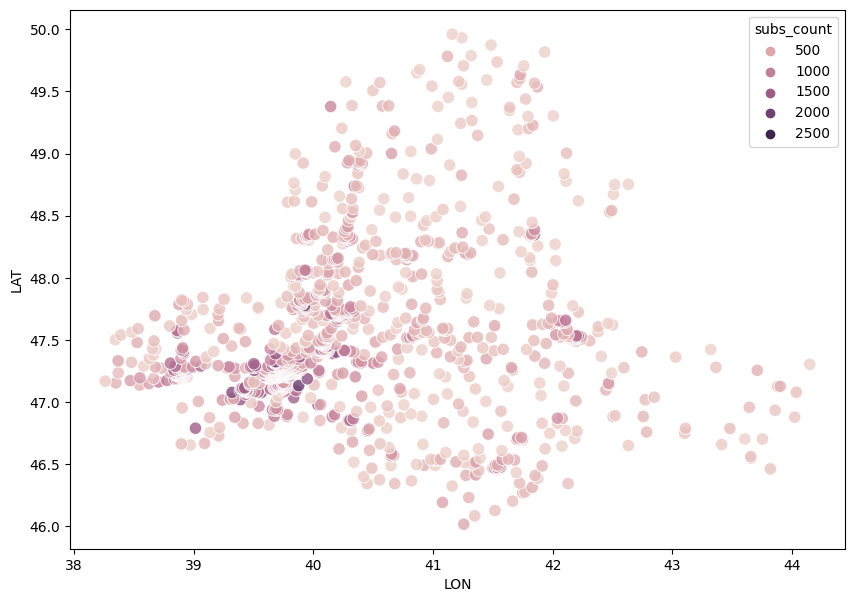

In [21]:
# Создаем датафрейм для распределения 
df_subs_count = df.groupby(['LAT', 'LON', 'ST_POINT'], as_index=False)['subs_id'].count()
df_subs_count = df_subs_count.rename(columns={'subs_id': 'subs_count'})

# Создаем scatterplot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_subs_count, x='LON', y='LAT', hue='subs_count', cmap='cool', s=80, alpha=0.8)

In [22]:
df_subs_count.sort_values(by='subs_count', ascending=False ) # распределение

,LAT,LON,ST_POINT,subs_count
351,47.215278,38.889111,POINT (38.889111 47.215278),2685
194,47.092220,39.390128,POINT (39.390128 47.09222),2654
434,47.230621,39.596564,POINT (39.596564 47.230621),2559
441,47.231750,38.895278,POINT (38.895278 47.23175),2495
472,47.237333,39.811944,POINT (39.811944 47.237333),2408
...,...,...,...,...
1289,48.762540,39.838040,POINT (39.83804 48.76254),2
1274,48.620038,42.214567,POINT (42.214567 48.620038),2
1352,49.576849,40.271710,POINT (40.27171 49.576849),2
1365,49.874025,41.484658,POINT (41.484658 49.874025),2


<Axes: >

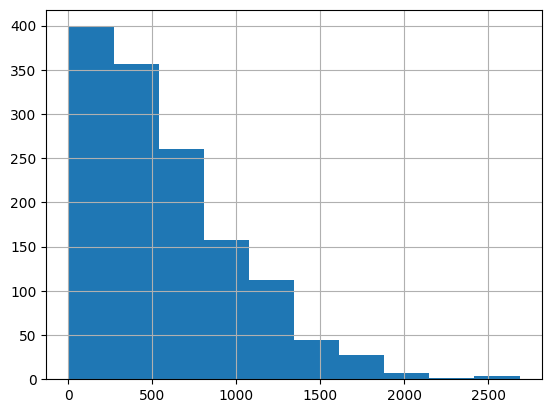

In [23]:
df_subs_count.subs_count.hist()

In [25]:
#находим выбросы
Q1 = df_subs_count["subs_count"].quantile(0.25)
Q3 = df_subs_count["subs_count"].quantile(0.75)
IQR = Q3 - Q1

# Определение границ выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Нахождение выбросов
outliers = df_subs_count[(df_subs_count['subs_count'] < lower_bound) | (df_subs_count['subs_count'] > upper_bound)]
outliers.subs_count.sort_values(ascending=True).head(5)

390     1733
810     1741
180     1743
1131    1749
414     1763
Name: subs_count, dtype: int64

In [ ]:
"red"
"blue"
"green"
"purple"
"orange"
"darkred"
"darkblue"
"darkgreen"
"cadetblue"
"pink"
"lightblue"
"gray"
"black"

In [53]:
#добавляем интерактив

# Создаем датафрейм для распределения подписчиков по регионам
df_subs_count = df.groupby(['LAT', 'LON', 'ST_POINT'], as_index=False)['subs_id'].count()
df_subs_count = df_subs_count.rename(columns={'subs_id': 'subs_count'})
# Создаем карту
m = folium.Map(location=[df_subs_count['LAT'].mean(), df_subs_count['LON'].mean()], zoom_start=5, tiles='Stamen Terrain')#Stamen Terrain CartoDB Positron
# Создаем точечные маркеры для каждой точки и добавляем их на карту
for i, row in df_subs_count.iterrows():
    if row['subs_count'] >= 2000:
        color = '#be1e2d'
    elif row['subs_count'] >= 1700 and row['subs_count'] < 2000:
        color = '#ff7f0e'
    elif row['subs_count'] >= 1000 and row['subs_count'] < 1700:
        color = '#a2dcaa'   
    else:
        color = '#2ca02c'
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=row['subs_count']/102,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        #tooltip=str([row['subs_count'], row ['ST_POINT']])
        tooltip="кол-во детракторов: " + str(row['subs_count']) + ", " +"BS_position: "+ str(row['ST_POINT'])
    ).add_to(m)
m.save("not HWE_2_st.html")

In [ ]:
#добавляем интерактив
# Создаем датафрейм для распределения подписчиков по регионам
df_subs_count = df_hwe_copy.query('flag_hwe == "1"').groupby(['LAT', 'LON', 'ST_POINT'], as_index=False)['subs_id'].count()
df_subs_count = df_subs_count.rename(columns={'subs_id': 'subs_count'})
# Создаем карту
m = folium.Map(location=[df_subs_count['LAT'].mean(), df_subs_count['LON'].mean()], zoom_start=5)
# Создаем точечные маркеры для каждой точки и добавляем их на карту
for i, row in df_subs_count.iterrows():
    if row['subs_count'] >= 72:
        color = 'red'
    elif row['subs_count'] > 45 and row['subs_count'] < 72:
        color = 'blue'
    else:
        color = 'green'

    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=row['subs_count']/19,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=str(row['subs_count'])
    ).add_to(m)
m#.save("HWE.html")

In [ ]:
# создаем список координат из df 
#Это строка кода создает список координат в формате, удобном для работы с модулем folium. 
# Она берет значения столбцов 'LAT' и 'LON' из датафрейма df и формирует список кортежей, содержащих значения этих столбцов. 
# Вот как это работает:df[['LAT', 'LON']] - выбираются столбцы 'LAT' и 'LON' из датафрейма df.values - преобразует эти столбцы в массив numpy.tolist() - преобразует массив numpy в список кортежей
locationlist = df[['LAT', 'LON']].values.tolist()

#итоговый вывод результата
#location - это определяет начальное местоположение карты. Здесь мы устанавливаем координаты [55.62252, 37.30162], что примерно соответствует городу Москва.
#tiles - это определяет тему карты. Мы выбрали тему 'CartoDB dark_matter', которая показывает карту в темной гамме.
#zoom_start - это задает начальный масштаб карты.
#Далее мы создаем объект marker_cluster - кластер маркеров для группировки сгенерированных маркеров на карте.
map3 = folium.Map(location=[47.222078, 39.720358], tiles='CartoDB dark_matter', zoom_start=8)
marker_cluster = MarkerCluster().add_to(map3)
# создаем маркеры на карте 
#Этот блок кода генерирует маркеры для каждой точки в списке координат locationlist и добавляет их в marker_cluster.
#Цикл for перебирает элементы locationlist - набор кортежей с координатами LAT и LON. 
# Для каждой точки мы создаем текстовое содержимое маркера (поле 'subs_id' из датафрейма df). 
# Затем мы добавляем маркер на карту используя folium.Marker. 
# В качестве аргументов этой функции мы передаем locationlist, координаты каждой точки, текстовое содержимое маркера (popup_text) и опции иконки маркера (icon).
# Мы добавляем каждый маркер в кластер marker_cluster с помощью метода .add_to().
#for point in range(0, min(len(locationlist), 1000)):
for point in range(len(locationlist)):
     # задаем текстовое содержимое маркера
    popup_text = f"ID:{df['subs_id'][point]}"
       # создаем маркер и добавляем его на карту
    folium.Marker(locationlist[point], popup=popup_text, icon=folium.Icon(icon='male', angle=0, prefix='fa')).add_to(marker_cluster)  
# выводим карту
map3#.save("map.html")

Для нахождения выбросов в столбце subs_id с помощью машинного обучения можно использовать алгоритмы аномалийного обнаружения, такие как One-Class SVM или Isolation Forest.

Пример кода для поиска выбросов с помощью One-Class SVM:

In [ ]:
#Пример кода для поиска выбросов с помощью Isolation Forest:
import pandas as pd
from sklearn.ensemble import IsolationForest
# Инициализация алгоритма Isolation Forest
clf = IsolationForest(n_estimators=100, contamination=0.05)
# Обучение алгоритма на данных
clf.fit(df_subs_count[['subs_count']])
# Определение, является ли каждое наблюдение выбросом (1) или нет (-1)
preds = clf.predict(df_subs_count[['subs_count']])
# Фильтрация выбросов
outliers = df_subs_count[preds == -1]
print(outliers)

In [ ]:
import pandas as pd
from sklearn.svm import OneClassSVM
# Инициализация алгоритма One-Class SVM
clf = OneClassSVM(kernel='rbf', nu=0.05)
# Обучение алгоритма на данных
clf.fit(df_subs_count[['subs_count']])
# Определение, является ли каждое наблюдение выбросом (1) или нет (-1)
preds = clf.predict(df_subs_count[['subs_count']])
# Фильтрация выбросов
outliers = df_subs_count[preds == -1]
print(outliers)